In [2]:
import pandas as pd
import numpy as np
import time
import cantera as ct
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("seaborn-v0_8")

In [ ]:
gas = ct.Solution('octane-mehl\octane-mehl.yaml')

In [4]:
reactor_temp = 1000 # K
reactor_pressure = 5*101325 # Pa
gas.TP = reactor_temp, reactor_pressure
gas.set_equivalence_ratio(phi=1.0, fuel="IC8H18", oxidizer={"o2": 1.0, "n2": 3.76})

r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])

time_history = ct.SolutionArray(gas, extra="t")

In [5]:
def ignition_delay(states, species):
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [6]:
reference_species = "oh"

t0 = time.time()
estimated_delay = 0.1
t = 0

counter = 1
while t < estimated_delay:
    t = reactor_network.step()
    if not counter % 10:
        time_history.append(r.thermo.state, t=t)
    counter += 1

tau = ignition_delay(time_history, reference_species)
t1 = time.time()
print(f"Computed ignition delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

Computed ignition delay: 9.939e-03 seconds. Took 47.36s to compute


Text(0, 0.5, '$Y_{OH}$')

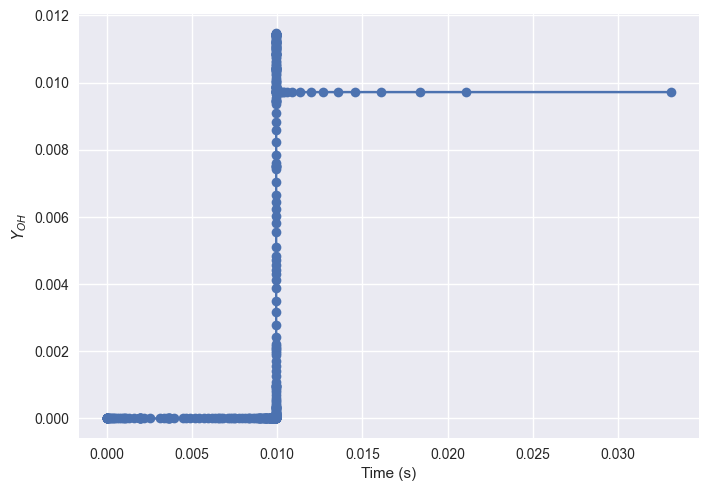

In [7]:
plt.figure()
plt.plot(time_history.t, time_history(reference_species).Y, '-o')
plt.xlabel("Time (s)")
plt.ylabel("$Y_{OH}$")

In [8]:
#T = np.arange(1000, 500, -50) # T array
T = np.arange(975, 475, -25)

estimated_delays = np.ones_like(T, dtype=float)
estimated_delays[:4] = 4 * [0.1]
estimated_delays[8:11] = 10
estimated_delays[-4:-2] = 10
estimated_delays[-2:] = 100

ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_delays})
ignition_delays.set_equivalence_ratio(0.5, fuel="IC8H18", oxidizer={"o2": 1.0, "n2": 3.76})
ignition_delays.TP = T, reactor_pressure

In [9]:
T

array([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675,
       650, 625, 600, 575, 550, 525, 500])

In [10]:
estimated_delays

array([  0.1,   0.1,   0.1,   0.1,   1. ,   1. ,   1. ,   1. ,  10. ,
        10. ,  10. ,   1. ,   1. ,   1. ,   1. ,   1. ,  10. ,  10. ,
       100. , 100. ])

In [11]:
for i, state in enumerate(ignition_delays):
    # gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])
    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_delays[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    print(f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T}K. Took {t1 - t0:3.2f}s to compute")

    ignition_delays[i].tau = tau

Computed Ignition Delay: 1.794e-02 seconds for T=2358.194034329912K. Took 39.24s to compute
Computed Ignition Delay: 2.658e-02 seconds for T=2339.2570648739443K. Took 42.45s to compute
Computed Ignition Delay: 4.104e-02 seconds for T=2320.2382623847575K. Took 44.73s to compute
Computed Ignition Delay: 6.690e-02 seconds for T=2301.1572653074727K. Took 45.14s to compute
Computed Ignition Delay: 1.143e-01 seconds for T=2282.032810843576K. Took 47.32s to compute
Computed Ignition Delay: 2.010e-01 seconds for T=2262.8817565953354K. Took 49.58s to compute
Computed Ignition Delay: 3.573e-01 seconds for T=2243.719790595317K. Took 47.37s to compute
Computed Ignition Delay: 6.262e-01 seconds for T=2224.5605277750774K. Took 55.32s to compute
Computed Ignition Delay: 1.030e+00 seconds for T=2205.414595217732K. Took 52.56s to compute
Computed Ignition Delay: 1.420e+00 seconds for T=2186.285897819689K. Took 59.31s to compute
Computed Ignition Delay: 1.315e+00 seconds for T=2167.159407730336K. Took 5

Text(0.5, 0, 'Temperature: $T (K)$')

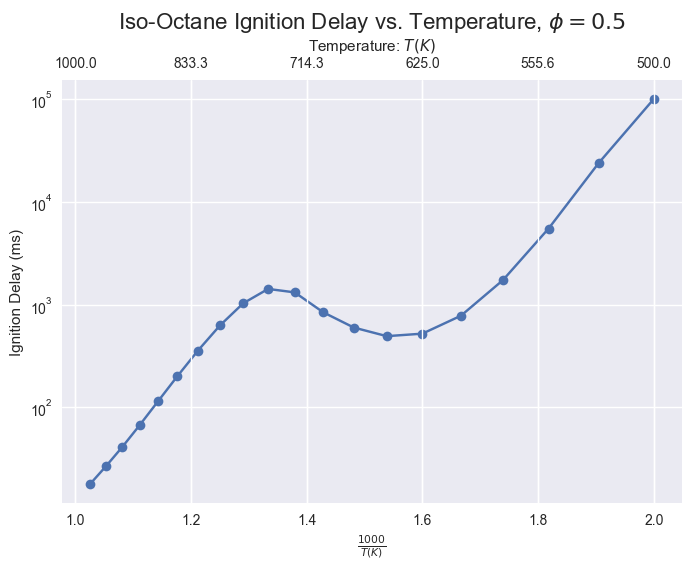

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / ignition_delays.T, ignition_delays.tau*1000, "o-")
ax.set_ylabel("Ignition Delay (ms)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$")
plt.title(r"Iso-Octane Ignition Delay vs. Temperature, $\phi = 0.5$", fontsize = 16)

ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T (K)$")